In [1]:
from copy import deepcopy
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def graph_progress(all_costs, all_accuracies, show_recents=True):
    # last 5 results
    # ---------------
    if show_recents:
        line1 = "cost: "
        line2 = "acc:  "
        if len(all_costs) < 5: show = len(all_costs)
        else:                  show = 5
        for i in range(-show, 0):
            line1 += "{:>8} ".format(round(all_costs[i], 5))
            line2 += "{:>8}%".format(round(all_accuracies[i]*100, 2))
        print(line1)
        print(line2)


    # graphs
    # -------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(range(len(all_costs)), all_costs, label="costs")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('cost') # Set a title of the current axes.
    axes[0].set_title('cost over training steps') 
    axes[0].legend() # show a legend on the plot

    axes[1].plot(range(len(all_accuracies)), all_accuracies, label="accuracies")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('accuracy') # Set a title of the current axes.
    axes[1].set_title('accuracy over training steps') 
    axes[1].legend() # show a legend on the plot

    return fig.tight_layout()

# import training data

In [3]:
import pandas as pd #1
import os           #3

In [4]:
given_data_folder = 'prepped'

file_names = os.listdir(given_data_folder)
file_names.sort()
file_names

['.DS_Store',
 'M_predictions.csv',
 'M_testing.csv',
 'M_training_data.csv',
 'M_training_data_embedding.csv',
 'W_predictions.csv',
 'W_testing.csv',
 'W_training_data.csv',
 'predictions']

In [5]:
training_data_file = 'M_training_data_embedding.csv'

In [6]:
file_path = given_data_folder + '/' + training_data_file 
training_df  = pd.read_csv(file_path)
print(len(training_df))

training_df.head(5)

46338


,team1_id,team2_id,Pts,FG%2,FGA2,FG%3,FGA3,FT%,FTA,OR,...,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xStr_a,solution
0,11872022.0,14412022.0,0.750000,0.633800,0.787037,0.439078,0.680556,0.750842,0.662162,0.605263,...,-0.567568,-0.605263,-0.675676,-0.479167,-0.659091,-0.538462,-0.500000,-0.621212,-0.847291,1
1,14412022.0,11872022.0,0.754902,0.658602,0.555556,0.582219,0.930556,0.601307,0.594595,0.578947,...,-0.675676,-0.578947,-0.770270,-0.354167,-0.659091,-0.807692,-0.375000,-0.606061,-0.400841,-1
2,12522022.0,12592022.0,0.833333,0.763211,0.648148,0.694010,0.555556,0.798333,0.662162,0.236842,...,-0.567568,-0.657895,-0.635135,-0.687500,-0.454545,-0.615385,-0.500000,-0.606061,-0.768758,1
3,12592022.0,12522022.0,0.699346,0.750538,0.629630,0.404228,0.712963,0.706472,0.513513,0.280702,...,-0.675676,-0.543860,-0.702703,-0.569444,-0.666667,-0.615385,-0.458333,-0.545455,-0.541014,-1
4,13292022.0,13412022.0,0.700980,0.737634,0.750000,0.435882,0.583333,0.632353,0.391892,0.684211,...,-0.297297,-0.394737,-0.567568,-0.312500,-0.863636,-0.538462,-0.562500,-0.439394,-0.598615,1


## get as rows

In [7]:
# wether or not to keep the data for stats against a team
keep_against = True

In [8]:
training_column_names = training_df.columns.tolist()

# get all data as columns
training_columns = []
for i in range(len(training_column_names)):
    new_column = list(training_df[training_column_names[i]])
    training_columns.append(new_column)
    

    
# indicis
# 30 each 0:15, 15:30, 30:45, 45:60
if not keep_against:
    new_training_columns = training_columns[0:15] + training_columns[30:45] + [training_columns[60]]
    training_columns = new_training_columns
    
    
    
# get as rows
training_input_rows    = []
training_solution_rows = []
embedding_key_rows     = []
for i in range(len(training_columns[0])):
    new_input_row         = []
    new_solution_row      = [training_columns[-1][i]]
    new_embedding_key_row = [int(training_columns[0][i]), int(training_columns[1][i])]
    for j in range(2, len(training_columns)-1):
        new_input_row.append(training_columns[j][i])
        
    training_input_rows   .append(new_input_row)
    training_solution_rows.append(new_solution_row)
    embedding_key_rows    .append(new_embedding_key_row)
    
print(len(training_input_rows), len(training_input_rows[0]))
print(len(training_solution_rows), len(training_solution_rows[0]))
print(len(embedding_key_rows), len(embedding_key_rows[0]))

46338 114
46338 1
46338 2


In [9]:
split = 7_000
np_inputs    = np.array(training_input_rows[:split])
np_solutions = np.array(training_solution_rows[:split])

embedding_key_rows = embedding_key_rows[:split]

#np_inputs    = np.array(training_input_rows)
#np_solutions = np.array(training_solution_rows)

np_data = [np_inputs, np_solutions]

# Create and Train population

In [10]:
import sys
sys.path.append("../../..")

from network_matrix.population_v3 import Population
from network_matrix.population_v3 import create_embedding

### create embeddings

In [11]:
'''
embedding_length = 75

unique_team_ids = []
embeddings_dict = {}
for i in range(len(embedding_key_rows)):
    row = embedding_key_rows[i]
    
    for team in row:
        if team not in unique_team_ids:
            unique_team_ids.append(team)
            embeddings_dict[team] = create_embedding(embedding_length, init_range=1.0)
        
embeddings_dict[11872022]
''';

In [12]:
#embedding_key_rows[0] # = [11872022, 14412022]

In [13]:
#embeddings_dict[11872022]

In [14]:

embedding_length = 75
num_inputs       = len(np_inputs[0])

unique_team_ids = []
embeddings_dict = {}
for i in range(len(embedding_key_rows)):
    row = embedding_key_rows[i]
    
    for team in row:
        if team not in unique_team_ids:
            unique_team_ids.append(team)
            embeddings_dict[team] = create_embedding((embedding_length, num_inputs), init_range=0.25)
        
#embeddings_dict[11872022][0]


In [15]:
sample_embedding = np.copy(embeddings_dict[11872022])

#sample_neuron = list(sample_embedding)
sample_neuron = list(sample_embedding[0])

s_average  = 0
s_abs_avg  = 0
s_norm_sum = 0

for weight in sample_neuron:
    s_average  += weight
    s_abs_avg  += abs(weight)
    s_norm_sum += weight
    
s_average = (s_average/len(sample_neuron))
s_abs_avg = (s_abs_avg/len(sample_neuron))

print("average: {:>6} | abs_avg: {:>6} | sum: {}".format(
    round(s_average,  4), 
    round(s_abs_avg,  4), 
    round(s_norm_sum, 4)
))

average: -0.0077 | abs_avg: 0.1202 | sum: -0.8723


In [16]:
#embeddings_dict[11872022][0]

### create it here

In [17]:
'''
learning_rate, steps, batch_size,    cost,      acc,
-------------- ------ ----------- -------- ---------
       0.0001,    50,          2,   0.215,   65.51%,
       
       0.0001     50,          2,   0.190,   71.27%,  # recent 5 games, no stats against
       0.0001    100,          2,   0.188,   71.19%,  # recent 5 games, with stats against
''';

num_inputs = len(np_inputs[0])
#num_inputs = len(np_inputs[0]) + (2*embedding_length)
num_inputs

114

In [18]:
4*60*60

14400

In [19]:
TEST_population  = Population(num_inputs, 1, learning_rate=0.001, embedding_size=int(num_inputs*3/2))

#TEST_population  = Population(num_inputs, 1, learning_rate=0.0001, embedding_size=(2*embedding_length))
#TEST_population  = Population(num_inputs, 1, learning_rate=0.001, embedding_size=num_inputs)

all_times = [0,0,0,0,0]
all_costs = []
all_accuracies = []

In [20]:
print(TEST_population.layers[-1]["weights"].shape)

(1, 171)


In [37]:
# training loops
# ---------------
#times, costs, accuracies = TEST_population.train_and_test(np_data, 6_000)
#times, costs, accuracies = TEST_population.train_and_test_stochastic(np_data, 100, batch_size=10)


times, data, costs, accuracies = TEST_population.train_and_test_base(np_inputs, 
                                                                     np_solutions,
                                                                     batch_size=100,
                                                                     steps=4000, 
                                                                     training_time=480, 
                                                                     use_time=True, 
                                                                     report_frequency=1
)


'''
times, data, costs, accuracies = TEST_population.train_and_test_embeddings(np_inputs, embedding_key_rows, 
                                                                           np_solutions, 
                                                                           embeddings_dict, 
                                                                           steps=9000,
                                                                           training_time=480,
                                                                           use_time=True,
                                                                           report_frequency=1
)

times, data, costs, accuracies = TEST_population.train_and_test_embeddings_WEIGHTS(np_inputs, embedding_key_rows, 
                                                                                   np_solutions, 
                                                                                   embeddings_dict, 
                                                                                   steps=4000,
                                                                                   training_time=120,
                                                                                   use_time=True,
                                                                                   report_frequency=1
)
                                    
'''

# update tracking
# ---------------
for i in range(len(all_times)):
    all_times[i] += times[i]
all_costs      += costs
all_accuracies += accuracies

Training Progress:                             |    cost     acc  |     steps           time      remaining  
                                               | --------  ------ | ----------  -------------  ------------- 


 
                  time(s)   percent  per step       | steps:              120
            -------------  --------  --------       | learning rate:    0.001
set inputs           0.4s      0.09%     0.01       | # connections:   136629
calc value       1m 43.1s     21.17%     1.72       | L1 (sum):        0.0001
grad dscnt       5m 39.6s     69.73%     5.66       | L2 (**2):        0.0021
update vals          1.6s      0.34%     0.03
scoring             41.5s      8.51%     0.69       
step time       16m 11.6s     100.0%    16.19

cost:  0.24326  0.24302  0.24278  0.24256  0.24229 
acc:     65.24%   65.62%   65.19%   65.19%   65.29%


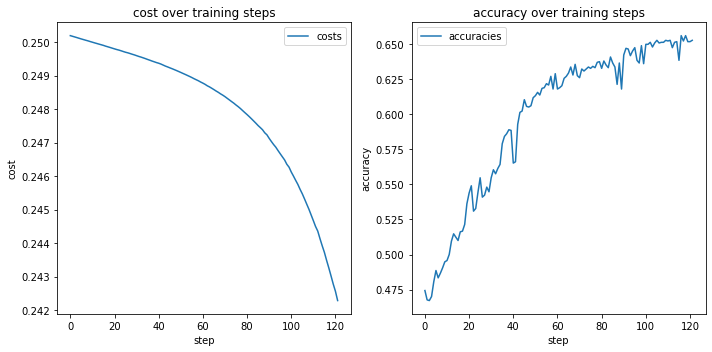

In [39]:
TEST_population.report_training_progress(all_times, data) # timing
graph_progress(all_costs, all_accuracies)                 # graphs
#graph_progress(all_costs[70:], all_accuracies[70:], show_recents=False) # graphs (recent)

In [23]:
TEST_population.print_magnitudes_report()


           abs_avg   abs_med       sum       max       min
          --------  --------  --------  --------  --------
values       0.542     0.575     2.442     0.973    -0.995
biases         0.0       0.0       0.0       0.0       0.0
weights      0.036     0.024    -5.623     0.337    -0.311
          --------  --------  --------  --------  --------
values       0.267     0.235     0.098      0.73    -0.816
biases         0.0       0.0       0.0       0.0       0.0
weights       0.03     0.019     8.432     0.301     -0.22
          --------  --------  --------  --------  --------
values       0.146     0.144     3.989     0.445    -0.368
biases         0.0       0.0       0.0       0.0       0.0
weights       0.03     0.019     -0.36     0.293    -0.267
          --------  --------  --------  --------  --------
values       0.074      0.06    -1.422     0.251    -0.254
biases         0.0       0.0       0.0       0.0       0.0
weights       0.03     0.019    -1.244     0.262    -0.

In [24]:
TEST_population.print_magnitudes_report()


           abs_avg   abs_med       sum       max       min
          --------  --------  --------  --------  --------
values       0.542     0.575     2.442     0.973    -0.995
biases         0.0       0.0       0.0       0.0       0.0
weights      0.036     0.024    -5.623     0.337    -0.311
          --------  --------  --------  --------  --------
values       0.267     0.235     0.098      0.73    -0.816
biases         0.0       0.0       0.0       0.0       0.0
weights       0.03     0.019     8.432     0.301     -0.22
          --------  --------  --------  --------  --------
values       0.146     0.144     3.989     0.445    -0.368
biases         0.0       0.0       0.0       0.0       0.0
weights       0.03     0.019     -0.36     0.293    -0.267
          --------  --------  --------  --------  --------
values       0.074      0.06    -1.422     0.251    -0.254
biases         0.0       0.0       0.0       0.0       0.0
weights       0.03     0.019    -1.244     0.262    -0.

In [25]:
new_sample_embedding = np.copy(embeddings_dict[11872022])

#new_sample_neuron = list(new_sample_embedding)
new_sample_neuron = list(new_sample_embedding[0])

change = 0

average  = 0
abs_avg  = 0
norm_sum = 0

for i in range(len(new_sample_neuron)):
    orig_w = sample_neuron[i]
    weight = new_sample_neuron[i]
    
    average  += weight
    abs_avg  += abs(weight)
    norm_sum += weight
    
    change += (weight-orig_w)
    
average = (average/len(new_sample_neuron))
abs_avg = (abs_avg/len(new_sample_neuron))

change = (change/len(new_sample_neuron))


print("OLD:      average: {:>7} | abs_avg: {:>7} | sum: {}".format(
    round(s_average,  4), 
    round(s_abs_avg,  4), 
    round(s_norm_sum, 4)
))


print("NEW:      average: {:>7} | abs_avg: {:>7} | sum: {}".format(
    round(average,  4), 
    round(abs_avg,  4), 
    round(norm_sum, 4)
))

print("CHANGE:   {}".format(change))


OLD:      average: -0.0077 | abs_avg:  0.1202 | sum: -0.8723
NEW:      average: -0.0077 | abs_avg:  0.1202 | sum: -0.8723
CHANGE:   0.0


In [26]:
'''
create embeddings
calculate num inputs
create test population
record values

values:
--------

steps/time
learning rate     - [0.01, 0.001, 0.0001]

embedding size    - [50, 75, 100]
neurons per layer - [1, 1.5, 2]
layers            - [1,2,3]

cost
accuracy

[-0.72383175]
[1.13564593]
[-4.14703678]
[3.30995677]
[3.73987126]
[-6.78590187]
[4.47202037]
[-5.16833236]
[2.4957738]
[-1.05856062]
[3.76802237]
[-4.41886608]
[5.08741867]
[-0.23680327]
[-2.70222323]
[3.68004333]
[-3.83485353]
[1.17818429]
[-1.17616444]
[0.17298058]
[-0.76645789]
[4.01161471]
[-3.74295765]
[1.78408998]
[4.1263263]
[-4.50350624]
[-2.54199513]
[5.70228093]
[-3.78165697]
[-0.3927466]
[1.16065072]
[-1.45276148]
[5.01859125]
[-3.09915987]
[-1.05334723]
[3.81865802]
[-2.22734303]
[2.8338316]
[1.75992775]
[-3.07603825]
[-3.3700461]
[3.05309275]
[-2.27501006]
[-0.66296897]
[3.44383752]
[-2.57672221]
[-2.32793955]
[2.58281851]
[-0.91397023]
[-2.01809243]
[4.34655069]
[1.90379848]
[-3.20581836]
[0.61568965]
[4.4766478]
[-3.03258218]
[-2.60835699]
[4.04092111]
[1.9259041]
[-2.56965]
[3.60626376]
[-4.73459113]
[-1.37565169]
[-0.86545982]
[3.04192589]


old

[-0.11783873  0.00863854 -0.10431334  0.02452002  0.00522983 -0.23687609
  0.13002336 -0.22897251 -0.24174758  0.05009583  0.07064174  0.15055666
 -0.19306719  0.20137571 -0.01941111 -0.23612443  0.18999594  0.24123012
  0.1394493  -0.13752703 -0.09443847  0.03010571  0.23178616  0.05707828
 -0.07564377  0.19056055 -0.20630282  0.18162342  0.1020699   0.14689828
  0.16066953 -0.07216362 -0.1639651  -0.20434558 -0.02192809 -0.10630754
 -0.02355929 -0.00663807 -0.0704983   0.09061832 -0.18074218  0.0052779
 -0.09234561  0.10671351  0.05796006 -0.02589949 -0.14350782 -0.12607149
 -0.22285823 -0.15661145 -0.15263906 -0.19973721  0.03865251 -0.25437531
 -0.00940026  0.11197241 -0.00660668 -0.22453837  0.07315953  0.17235723
  0.1999117   0.04798949  0.08882527 -0.2065553   0.2453784  -0.07306001
  0.24877829 -0.10818403 -0.23509703 -0.18112227  0.1280429  -0.14161153
  0.2433819  -0.16497541 -0.06951603 -0.06555819  0.16563227 -0.04989101
 -0.05766004  0.16457384 -0.04383063  0.20570952 -0.20571765  0.02317843
 -0.08978175 -0.07352925 -0.16542104 -0.13266355 -0.22485317  0.0211347
 -0.23464246 -0.20663028 -0.16001541 -0.19688082  0.00196723 -0.07859316
  0.04973935 -0.09983323  0.07346632  0.18607269  0.19978743  0.18503013
 -0.2105172  -0.08597663  0.00345986  0.25428411  0.02780476  0.1305638
 -0.10290878 -0.13247146  0.12480071  0.11310695  0.00856541  0.22892001]


#1 of the 4
[-0.1463689   0.01073004 -0.12956886  0.03045661  0.00649603 -0.29422664
  0.16150358 -0.28440951 -0.30027758  0.06222463  0.08774495  0.18700824
 -0.23981108  0.25013119 -0.02411077 -0.293293    0.23599624  0.29963483
  0.17321165 -0.17082398 -0.11730316  0.03739466  0.28790438  0.07089762
 -0.09395803  0.23669756 -0.25625122  0.22559664  0.12678225  0.18246412
  0.19956956 -0.0896353  -0.20366303 -0.2538201  -0.02723715 -0.13204587
 -0.02926328 -0.00824523 -0.08756678  0.11255811 -0.22450204  0.00655575
 -0.11470359  0.13255014  0.07199289 -0.03217006 -0.17825279 -0.15659491
 -0.27681489 -0.19452897 -0.18959481 -0.24809599  0.04801075 -0.31596264
 -0.01167617  0.13908227 -0.00820624 -0.27890182  0.09087233  0.21408699
  0.24831273  0.05960832  0.11033094 -0.25656482  0.30478747 -0.09074872
  0.3090105  -0.13437668 -0.29201684 -0.22497415  0.15904363 -0.17589739
  0.30230759 -0.20491794 -0.08634669 -0.08143062  0.20573383 -0.06197023
 -0.07162023  0.20441915 -0.05444255  0.25551426 -0.25552437  0.02879021
 -0.111519   -0.09133157 -0.20547146 -0.16478299 -0.27929283  0.02625167
 -0.29145222 -0.25665796 -0.19875707 -0.24454803  0.00244352 -0.09762151
  0.06178184 -0.12400406  0.0912534   0.23112312  0.24815837  0.22982816
 -0.26148594 -0.10679261  0.00429753  0.31584935  0.03453663  0.16217487
 -0.12782423 -0.16454439  0.15501647  0.1404915   0.01063919  0.2843443 ]

# swap mult (middl)
[-0.16793027  0.01231066 -0.14865545  0.03494313  0.00745295 -0.33756871
  0.18529442 -0.32630543 -0.344511    0.07139084  0.10067053  0.21455613
 -0.27513727  0.28697763 -0.02766249 -0.33649753  0.27076048  0.34377357
  0.19872719 -0.19598779 -0.1345829   0.04290321  0.33031512  0.08134143
 -0.10779884  0.2715651  -0.29399918  0.25882892  0.14545834  0.20934262
  0.22896784 -0.10283934 -0.23366431 -0.29120995 -0.03124941 -0.15149734
 -0.033574   -0.00945982 -0.10046611  0.12913887 -0.25757308  0.00752146
 -0.1316004   0.15207589  0.08259805 -0.03690898 -0.20451093 -0.17966266
 -0.31759205 -0.22318473 -0.21752373 -0.28464262  0.05508314 -0.3625066
 -0.01339617  0.15957026 -0.00941509 -0.31998641  0.10425859  0.24562381
  0.28489129  0.06838913  0.12658362 -0.29435898  0.34968523 -0.10411677
  0.35453035 -0.1541715  -0.33503339 -0.25811474  0.1824721  -0.20180856
  0.34684005 -0.23510408 -0.09906629 -0.09342604  0.23604016 -0.07109896
 -0.0821705   0.23453181 -0.0624624   0.29315367 -0.29316526  0.03303124
 -0.12794669 -0.10478547 -0.23573914 -0.18905691 -0.32043502  0.03011876
 -0.33438559 -0.29446584 -0.22803566 -0.28057202  0.00280347 -0.11200198
  0.07088283 -0.1422709   0.1046958   0.26516951  0.28471419  0.26368378
 -0.30000503 -0.12252406  0.00493059  0.36237662  0.03962416  0.18606459
 -0.14665382 -0.18878317  0.1778517   0.16118709  0.01220644  0.32623061]
 
 
 
''';

In [27]:
'''
# middles with tanh

[ 0.44907467 -0.03292085  0.39753044 -0.09344398 -0.01993048  0.90271725
 -0.4955094   0.87259729  0.92128215 -0.1909115  -0.26921044 -0.5737603
  0.73576477 -0.76742793  0.07397431  0.89985275 -0.72406046 -0.91931012
 -0.53143096  0.52410533  0.35989802 -0.11473063 -0.8833199  -0.2175211
  0.2882728  -0.72621217  0.78620478 -0.69215342 -0.38898083 -0.55981847
 -0.6122997   0.27501021  0.62485887  0.77874589  0.08356634  0.40513016
  0.0897827   0.0252972   0.26866379 -0.34533973  0.68879509 -0.0201137
  0.35192229 -0.40667731 -0.22088151  0.09870102  0.54689769  0.48044911
  0.84929621  0.59683465  0.58169617  0.76118372 -0.14730186  0.9694055
  0.03582368 -0.42671855  0.02517757  0.85569913 -0.27880554 -0.65684065
 -0.76184871 -0.18288439 -0.33850654  0.78716696 -0.93511893  0.27842629
 -0.94807564  0.41228133  0.89593737  0.69024356 -0.48796203  0.53967108
 -0.92751043  0.62870907  0.26492044  0.24983743 -0.63121231  0.19013096
  0.21973816 -0.62717873  0.16703529 -0.78394374  0.78397474 -0.08833128
  0.34215162  0.28021453  0.63040733  0.50557096  0.8568988  -0.08054278
  0.89420504  0.78745272  0.60980689  0.75029823 -0.00749696  0.29951271
 -0.18955298  0.38045706 -0.27997471 -0.70910924 -0.7613751  -0.70513615
  0.80226546  0.32765058 -0.01318525 -0.96905791 -0.10596188 -0.49756898
  0.39217774  0.50483893 -0.47560629 -0.43104222 -0.03264213 -0.87239722]


''';

In [28]:
'''
[ 1.9018924  -4.06993031 -4.14753532  2.37148048  1.37991472  2.92957658
  1.48577266  7.87255822  2.14280241  3.76948898 -2.09319859 -3.82639823
  1.71755874  7.373037   -1.74749259 -1.66226714 -3.88784093 -6.95934784
 -1.15951576  1.6833907   0.47400815 -4.2271603   0.79812254  3.65658523
 -1.34057905 -7.85487675 -0.27058865  6.42625094 -1.68800054  9.23660249
 -5.07363849  2.55797088  1.65804168  8.92240126  0.06530703 -1.08031994
 -0.74477114 -1.32408448 -3.32152288  2.34727204 -0.17152773  8.65247753
  7.59703996  1.19085281 -6.4137089  -2.71769278 -5.22428554 -2.40755892
  6.98239556 -6.12131763 -2.8567065   2.51252049 -2.52857245  0.90721049
 -4.13644032 -1.04216795  2.52647005  1.74359265 -4.74727834 -2.03026825
  8.11937827 -4.53422362  1.06094789  2.91997795  1.2885032   4.43198887
 -3.11145558  9.11538675 -1.72964257 -5.42150958 -2.09462502 -2.07793367
 -1.40802633  2.17752169  2.97071548 -5.72844703 -0.24977795 -0.62498252
  1.83835564  3.59003363 -6.09187871  4.74407554  5.80881205 -0.55005587
 -1.92741101 -2.14812469  6.04260996 -4.3176181  -5.10904657  0.55197559
 -0.31568253  5.88860089 -1.60265323  0.25121221 -5.97363596  6.17699513
  7.99978897  4.87960397  4.0722268  -1.62475566  1.28912152 -0.32174531
  0.25869224 -0.10338295  6.42450878 -4.95062891 -5.43574402  5.7587411
 -6.17115979  6.26572661  2.3682954  -5.97615088  6.04458463  1.44890901]
 
[-0.46764204  0.84293214  2.10195147 -1.82406043 -0.49634265 -0.60298874
 -1.37581508 -2.69984655 -0.31663753 -0.68555051  0.06171935  0.43211381
 -0.66039818 -2.17690508  0.87275006  0.52171986  2.08982766  2.18370553
 -0.24669336 -0.59936353  0.18102404  0.65311585  0.29156974 -0.29618163
  0.70617748  3.29994196  0.63013259 -1.65556853  0.16100321 -2.47111301
  2.14531314 -1.29406148 -0.07692803 -2.45216155 -0.32577352 -0.08192167
  0.28567756  0.12785297  0.54966429 -1.42829941  0.80594417 -2.20755624
 -1.95543188  0.0904675   1.31201615  0.2359808   1.04642751  0.11129976
 -2.31462357  1.3779267   0.31240829 -1.26914492  1.3314201   0.42872206
  1.93483534  0.88102344 -1.38400683  0.48241903  1.06638506  0.01024759
 -1.82432329  1.53206479 -0.64656492 -0.45252455 -1.5503663  -1.76346046
  0.23198731 -1.78679471  0.94299677  1.41333325  0.29727093  1.07906843
  0.66697039  0.02929538 -0.546577    1.77011566  0.54856645  0.2971812
 -1.02088308 -0.46972211  1.03341443 -1.33726812 -1.14610157 -0.13457071
  0.4455136   1.09829863 -1.49563927  1.10028346  1.73340897  0.21387033
  0.26135789 -1.10374072  0.84054785  0.24795276  1.67928456 -1.23952071
 -2.20596492 -1.23551206 -0.76729726  0.93937734  0.37907057  0.72390058
 -0.90377724 -0.65791245 -1.21548728  1.03134111  1.83799897 -2.48031461
  1.23222904 -1.54764137  0.04794864  2.02729449 -1.98085373 -0.4165625 ]

''';

In [29]:
test1 = np.array([[0,1,2], 
                  [3,4,5], 
                  [6,7,8]])

test2 = np.array([0,1,2])

print(test1.shape)
print(test2.shape)
test1

(3, 3)
(3,)


array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [30]:
test4 = np.swapaxes(test1, 0, 1)
test4

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [31]:
test3 = np.multiply(test1, test2)

test3

array([[ 0,  1,  4],
       [ 0,  4, 10],
       [ 0,  7, 16]])

In [32]:
np.sum(test1, axis=0)

array([ 9, 12, 15])

In [33]:
test5 = np.array([0,1,2])
test6 = np.array([3,4,5])

test7 = np.array([6,7,8])
test8 = np.array([9,0,1])

print(np.dot(test5, test6))
print(np.dot(test7, test8))
print()


test10 = np.outer(test5, test6)
test9  = np.outer(test7, test8)
print(test10)
print(test9)
print()

test11 = test9*test10 # print(np.multiply(test9, test10))
print(test11)
print()

#print(np.sum(test11, axis=1))
print(np.sum(test11, axis=0))
print()

print(np.dot(test10, test9))
#print(np.dot(test9, test10))
print()

test12 = np.dot(test10, test9)
sum_12 = np.sum(test12, axis=0)
print(sum_12)


#print(np.outer(test5, test6))
#print(np.outer(test6, test5))

14
62

[[ 0  0  0]
 [ 3  4  5]
 [ 6  8 10]]
[[54  0  6]
 [63  0  7]
 [72  0  8]]

[[  0   0   0]
 [189   0  35]
 [432   0  80]]

[621   0 115]

[[   0    0    0]
 [ 774    0   86]
 [1548    0  172]]

[2322    0  258]


In [34]:
test7 = np.array([[0,1,2], 
                  [3,4,5], 
                  [6,7,8]])
print(np.multiply(test7, test7))
print(np.dot(test7, test7))

[[ 0  1  4]
 [ 9 16 25]
 [36 49 64]]
[[ 15  18  21]
 [ 42  54  66]
 [ 69  90 111]]


In [35]:
test7 = np.array([[0,1,2], 
                  [3,4,5], 
                  [6,7,8]])

test10 = np.outer(test7, test7)
print(np.sum(test7, axis=1))
print(np.dot(test7, test7))

[ 3 12 21]
[[ 15  18  21]
 [ 42  54  66]
 [ 69  90 111]]


In [36]:
costs = np.array([0,1,2])
tanhP = np.array([3,4,5])
print(test8.shape)

test10 = np.outer(test8, test9)

print(np.outer(test8, test9))
print(np.dot(test8, test9))
print(np.dot(test10, test10))

(3,)
[[486   0  54 567   0  63 648   0  72]
 [  0   0   0   0   0   0   0   0   0]
 [ 54   0   6  63   0   7  72   0   8]]
[558   0  62]


ValueError: shapes (3,9) and (3,9) not aligned: 9 (dim 1) != 3 (dim 0)

In [ ]:
test8 = np.array([[0,1,2]])
test9 = np.array([[3,4,5]])
print(test8.shape)

test1 = test8.reshape((test8.shape[1],))
print(test1.shape)
print(test1)
print()

test10 = np.outer(test8, test9)

print(np.outer(test8, test9))
print(np.dot(test8, test9))
print(np.dot(test10, test10))

In [ ]:
test1 = np.array([0,1,2])
test2 = np.array([3,4,5])

test3 = np.outer(test1, test2)
print(test3.shape)
print(test3)
print()

test_d = np.multiply(test1, test3)
test_s = np.sum(test_d, axis=0)
print(test_d)
print(test_s)
print("------------\n\n")


test8 = np.array([[0,1,2]])
test9 = np.array([[3,4,5]])

test4 = np.outer(test8, test9)
print(test4.shape)
print(test4)
print()


test5 = np.outer(test8, test8)
test6 = np.outer(test9, test9)
t56 = np.dot(test5, test6)
t65 = np.dot(test6, test5)
print(np.sum(t56, axis=0))
print(np.sum(t65, axis=0))
print()


print(np.sum(np.dot(test4, test4), axis=1))

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
y = np.array([-1, 1])
y_pred = np.array([0, 0])

In [ ]:
y = np.array([1, 0])
y_pred = np.array([0.5, 0.5])

In [ ]:
y = np.array([[1, 0]])
y_pred = np.array([[0.365, 0.635]])

In [ ]:
loss = log_loss(y, y_pred)
loss